##### GLDADec (Our Proposed) deconvolution on GSE239996-APAP
- We downloaded the processed data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE239996.
- Acetaminophen (APAP) induced liver injury rat models.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_DIR = '/workspace/github/GLDADec' # cloning repository
import sys
sys.path.append(BASE_DIR)

from run import pipeline

***
#### Load data

In [2]:
raw_df = pd.read_csv(BASE_DIR+'/data/GSE239996/rat_dili_expression.csv',index_col=0)
random_sets = pd.read_pickle(BASE_DIR+'/data/random_info/100_random_sets.pkl')
target_facs = pd.read_csv(BASE_DIR+'/data/GSE239996/rat_dili_facs.csv',index_col=0)

***
#### Conduct GLDADec
- We added 1000 genes with large coefficients of variation between samples.
- To highlight the difference of trafficking of immune cells due to perturbation, a sample-wide minmax correction was performed as a preprocessing step.
- The cell types to be evaluated are as follows:
    1. 'B cells'
    2. 'T cells'
    3. 'Monocytes'
    4. 'NK cells'
    5. 'Neutrophils'

***
##### 1. Classical Markers (obtained from Natasha’s work: doi.org/10.4049/immunohorizons.2100088)
- 7 additonal topics were considered as the optimal number.

In [3]:
marker_dic1 = pd.read_pickle(BASE_DIR+'/data/marker/rat_liver_classical.pkl')

  0%|          | 0/10 [00:00<?, ?it/s]

cells in res : ['Neu', 'Mon', 'T', 'NK', 'B']
cells in ref : ['B', 'CD4T', 'CD8T', 'Mon', 'NK', 'Neu']


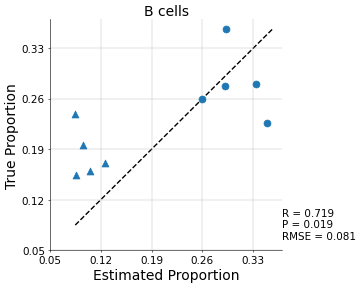

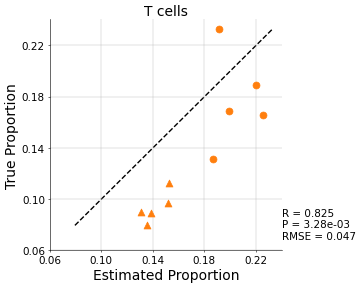

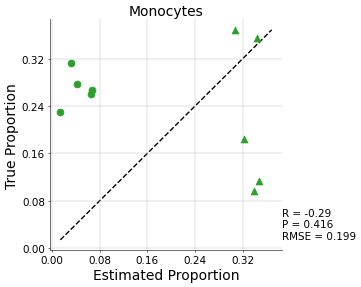

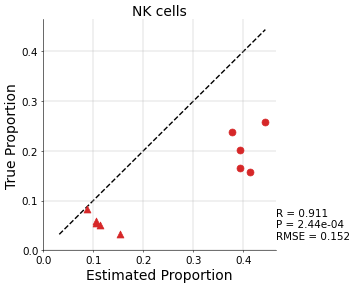

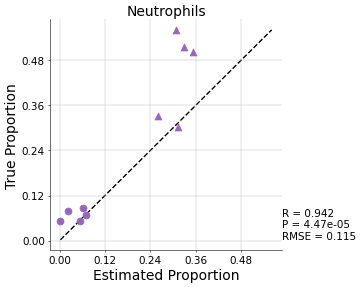

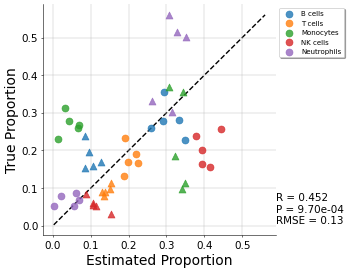

{'B cells': [('R', 0.7186), ('P', 0.019), ('RMSE', 0.0808)],
 'Monocytes': [('R', -0.2903), ('P', 0.416), ('RMSE', 0.1991)],
 'NK cells': [('R', 0.9112), ('P', '2.44e-04'), ('RMSE', 0.1524)],
 'Neutrophils': [('R', 0.9425), ('P', '4.47e-05'), ('RMSE', 0.115)],
 'T cells': [('R', 0.8254), ('P', '3.28e-03'), ('RMSE', 0.0468)]}
0.4525


In [4]:
# conduct deconv
pp = pipeline.Pipeline(verbose=False)
pp.from_predata(raw_df,target_samples=['liver-ctrl','liver-apap'],
                    do_ann=False,linear2log=False,log2linear=False,do_drop=True,do_batch_norm=False,do_quantile=False)
pp.gene_selection(method='CV',outlier=True,topn=1000)
pp.add_marker_genes(target_cells=['Neu', 'Mon','T', 'NK', 'B'],add_dic=marker_dic1)
pp.deocnv_prep(random_sets=random_sets,do_plot=False,specific=True,prior_norm=True,norm_scale=1,minmax=True,mm_scale=10)
pp.deconv(n=10,add_topic=7,n_iter=100,alpha=0.01,eta=0.01,refresh=10,initial_conf=1.0,seed_conf=1.0,other_conf=0.0,ll_plot=False,var_plot=False)

# evaluate
pp.evaluate(facs_df=target_facs,deconv_norm_range=['Neu', 'Mon','T', 'NK', 'B'], 
                facs_norm_range=['B', 'CD4T', 'CD8T', 'Mon', 'NK', 'Neu'],
                res_names=[['B'],['T'],['Mon'],['NK'],['Neu']],
                ref_names=[['B'],['CD4T','CD8T'],['Mon'],['NK'],['Neu']],
                title_list = ['B cells', 'T cells', 'Monocytes', 'NK cells', 'Neutrophils'],
                target_samples = ['liver-ctrl','liver-apap'],
                dpi=50,plot_size=100,multi=False,overlap=True)
print(pp.total_cor)

***
##### 2. Mouse marker genes obtaied from CellMarker
- This is the same marker used in the analysis of GSE237801.
- 4 additonal topics were considered as the optimal number.

In [5]:
marker_dic2 = pd.read_pickle(BASE_DIR+'/data/marker/mouse_liver_CellMarker.pkl')

  0%|          | 0/10 [00:00<?, ?it/s]

cells in res : ['B cell', 'Monocyte', 'Neutrophil', 'Natural killer cell', 'Effector memory T cell']
cells in ref : ['B', 'CD4T', 'CD8T', 'Mon', 'NK', 'Neu']


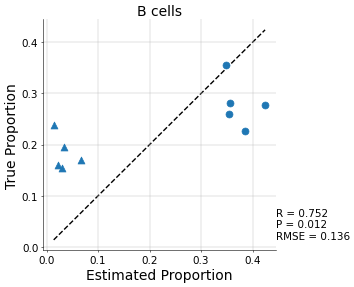

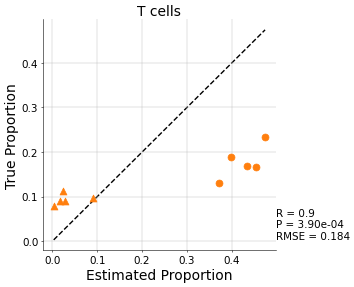

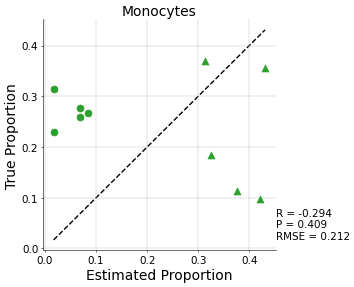

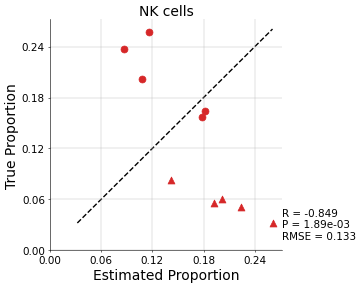

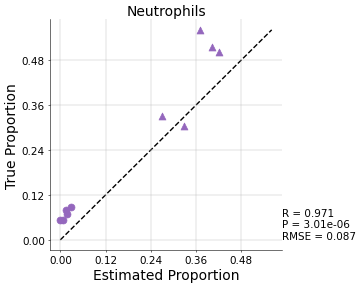

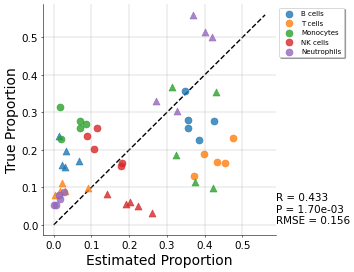

{'B cells': [('R', 0.7515), ('P', 0.012), ('RMSE', 0.1357)],
 'Monocytes': [('R', -0.2942), ('P', 0.409), ('RMSE', 0.2118)],
 'NK cells': [('R', -0.849), ('P', '1.89e-03'), ('RMSE', 0.1326)],
 'Neutrophils': [('R', 0.9709), ('P', '3.01e-06'), ('RMSE', 0.0867)],
 'T cells': [('R', 0.8998), ('P', '3.90e-04'), ('RMSE', 0.1835)]}
0.4327


In [6]:
pp = pipeline.Pipeline(verbose=False)
pp.from_predata(raw_df,target_samples=['liver-ctrl','liver-apap'],
                    do_ann=False,linear2log=False,log2linear=False,do_drop=True,do_batch_norm=False,do_quantile=False)
pp.gene_selection(method='CV',outlier=True,topn=1000)
pp.add_marker_genes(target_cells=[],add_dic=marker_dic2)
pp.deocnv_prep(random_sets=random_sets,do_plot=False,specific=True,prior_norm=True,norm_scale=1,minmax=True,mm_scale=10)
pp.deconv(n=10,add_topic=4,n_iter=100,alpha=0.01,eta=0.01,refresh=10,initial_conf=1.0,seed_conf=1.0,other_conf=0.0,ll_plot=False,var_plot=False)

# evaluate
pp.evaluate(facs_df=target_facs,deconv_norm_range=['B cell', 'Monocyte', 'Neutrophil', 'Natural killer cell', 'Effector memory T cell'], 
                facs_norm_range=['B', 'CD4T', 'CD8T', 'Mon', 'NK', 'Neu'],
                res_names=[['B cell'],['Effector memory T cell'],['Monocyte'],['Natural killer cell'],['Neutrophil']],
                ref_names=[['B'],['CD4T','CD8T'],['Mon'],['NK'],['Neu']],
                title_list = ['B cells', 'T cells', 'Monocytes', 'NK cells', 'Neutrophils'],
                target_samples = ['liver-ctrl','liver-apap'],
                dpi=50,plot_size=100,multi=False,overlap=True)
print(pp.total_cor)

***
##### 3. DEGs from mouse LM6
- DEGs were calculated for the six cell types (LM6) to be evaluated out of LM13 that were defined in our previous research (https://github.com/mizuno-group/LiverDeconv).
- 8 additonal topics were considered as the optimal number.

In [7]:
marker_dic3 = pd.read_pickle(BASE_DIR+'/data/marker/mouse_LM6_DEGs.pkl')

  0%|          | 0/10 [00:00<?, ?it/s]

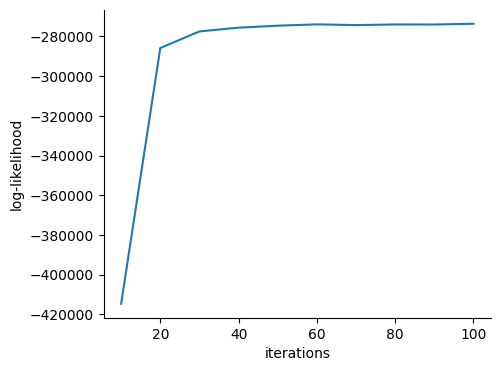

cells in res : ['B', 'CD4', 'CD8', 'Monocyte', 'NK', 'Neutrophil']
cells in ref : ['B', 'CD4T', 'CD8T', 'Mon', 'NK', 'Neu']


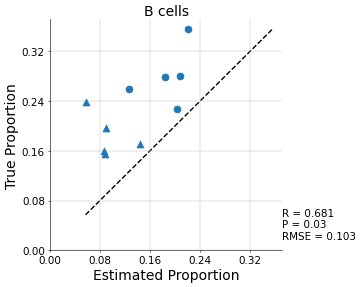

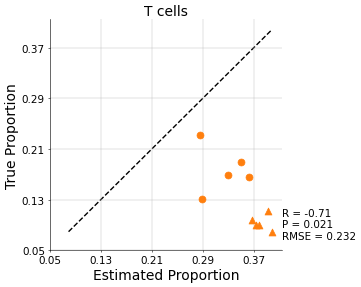

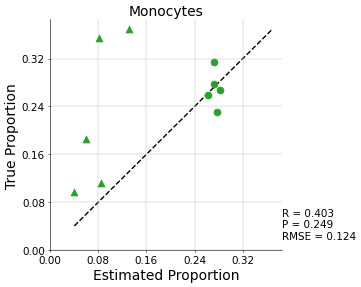

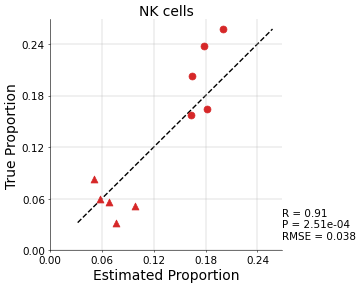

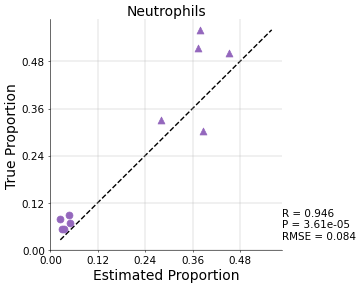

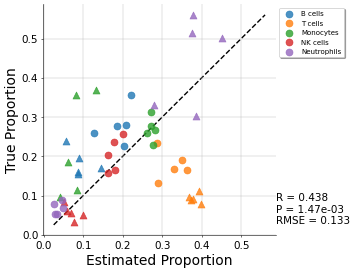

{'B cells': [('R', 0.6814), ('P', 0.03), ('RMSE', 0.1026)],
 'Monocytes': [('R', 0.4026), ('P', 0.249), ('RMSE', 0.1243)],
 'NK cells': [('R', 0.9105), ('P', '2.51e-04'), ('RMSE', 0.0376)],
 'Neutrophils': [('R', 0.9455), ('P', '3.61e-05'), ('RMSE', 0.0839)],
 'T cells': [('R', -0.7104), ('P', 0.021), ('RMSE', 0.2315)]}
0.4378


In [8]:
pp = pipeline.Pipeline(verbose=False)
pp.from_predata(raw_df,target_samples=['liver-ctrl','liver-apap'],
                    do_ann=False,linear2log=False,log2linear=False,do_drop=True,do_batch_norm=False,do_quantile=False)
pp.gene_selection(method='CV',outlier=True,topn=1000)
pp.add_marker_genes(target_cells=[],add_dic=marker_dic3)
pp.deocnv_prep(random_sets=random_sets,do_plot=False,specific=True,prior_norm=True,norm_scale=1,minmax=True,mm_scale=10)
pp.deconv(n=10,add_topic=8,n_iter=100,alpha=0.01,eta=0.01,refresh=10,initial_conf=1.0,seed_conf=1.0,other_conf=0.0,ll_plot=True,var_plot=False)

# evaluate
pp.evaluate(facs_df=target_facs,deconv_norm_range=['B','CD4','CD8','Monocyte','NK','Neutrophil'], 
                facs_norm_range=['B', 'CD4T', 'CD8T', 'Mon', 'NK', 'Neu'],
                res_names=[['B'],['CD4','CD8'],['Monocyte'],['NK'],['Neutrophil']],
                ref_names=[['B'], ['CD4T','CD8T'], ['Mon'], ['NK'], ['Neu']],
                title_list = ['B cells', 'T cells', 'Monocytes', 'NK cells', 'Neutrophils'],
                target_samples = ['liver-ctrl','liver-apap'],
                dpi=50,plot_size=100,multi=False,overlap=True)
print(pp.total_cor)